
file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:00<00:00, 27.2MB/s]
Extracting zip file...
Successfully downloaded / unzipped to .
Iter size: 156


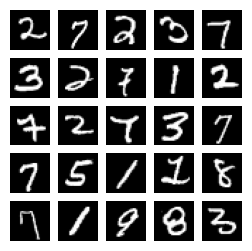

time of epoch 1 is 6.56s
time of epoch 2 is 6.80s
time of epoch 3 is 6.50s
time of epoch 4 is 6.50s
time of epoch 5 is 6.54s
time of epoch 6 is 6.27s
time of epoch 7 is 6.28s
time of epoch 8 is 6.51s
time of epoch 9 is 6.33s
time of epoch 10 is 6.27s
time of epoch 11 is 6.12s
time of epoch 12 is 6.58s
time of epoch 13 is 6.33s
time of epoch 14 is 6.75s
time of epoch 15 is 6.53s
time of epoch 16 is 6.31s
time of epoch 17 is 6.55s
time of epoch 18 is 6.52s
time of epoch 19 is 6.35s
time of epoch 20 is 6.57s
time of epoch 21 is 6.62s
time of epoch 22 is 6.64s
time of epoch 23 is 6.57s
time of epoch 24 is 6.51s
time of epoch 25 is 6.28s


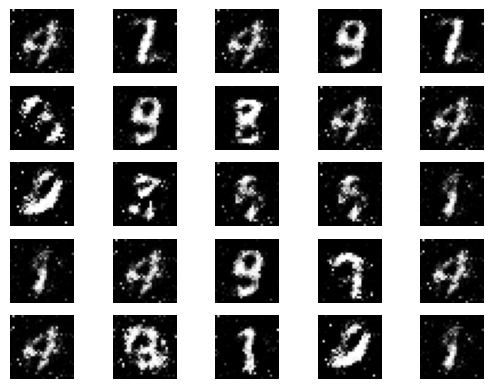

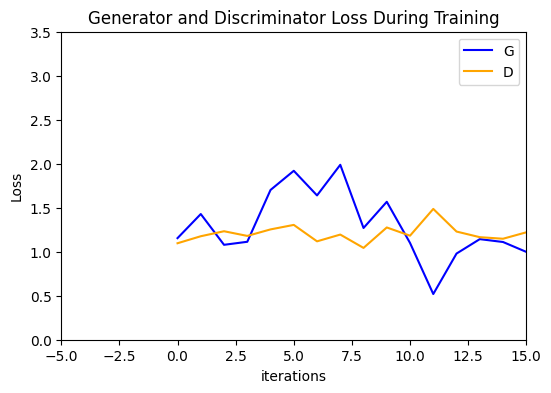

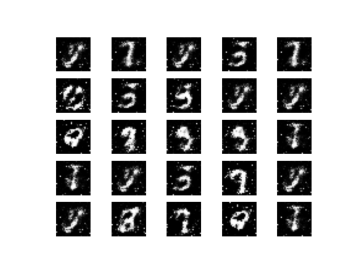

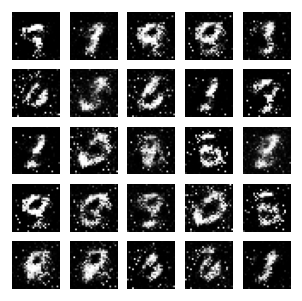

当前北京时间： 2024-12-28 20:02:13 name


In [6]:

# 数据下载
from download import download
 
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip"
download(url, ".", kind="zip", replace=True)
 
 
import numpy as np
import mindspore.dataset as ds
 
batch_size = 64
latent_size = 100  # 隐码的长度
 
train_dataset = ds.MnistDataset(dataset_dir='./MNIST_Data/train')
test_dataset = ds.MnistDataset(dataset_dir='./MNIST_Data/test')
 
def data_load(dataset):
    dataset1 = ds.GeneratorDataset(dataset, ["image", "label"], shuffle=True, python_multiprocessing=False, num_samples=10000)
    # 数据增强
    mnist_ds = dataset1.map(
        operations=lambda x: (x.astype("float32"), np.random.normal(size=latent_size).astype("float32")),
        output_columns=["image", "latent_code"])
    mnist_ds = mnist_ds.project(["image", "latent_code"])
 
    # 批量操作
    mnist_ds = mnist_ds.batch(batch_size, True)
 
    return mnist_ds
 
mnist_ds = data_load(train_dataset)
 
iter_size = mnist_ds.get_dataset_size()
print('Iter size: %d' % iter_size)
 
 
 
import matplotlib.pyplot as plt
 
data_iter = next(mnist_ds.create_dict_iterator(output_numpy=True))
figure = plt.figure(figsize=(3, 3))
cols, rows = 5, 5
for idx in range(1, cols * rows + 1):
    image = data_iter['image'][idx]
    figure.add_subplot(rows, cols, idx)
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
plt.show()
 
 
 
import random
import numpy as np
from mindspore import Tensor
from mindspore.common import dtype
 
# 利用随机种子创建一批隐码
np.random.seed(2323)
test_noise = Tensor(np.random.normal(size=(25, 100)), dtype.float32)
random.shuffle(test_noise)
 
 
from mindspore import nn
import mindspore.ops as ops
 
img_size = 28  # 训练图像长（宽）
 
class Generator(nn.Cell):
    def __init__(self, latent_size, auto_prefix=True):
        super(Generator, self).__init__(auto_prefix=auto_prefix)
        self.model = nn.SequentialCell()
        # [N, 100] -> [N, 128]
        # 输入一个100维的0～1之间的高斯分布，然后通过第一层线性变换将其映射到256维
        self.model.append(nn.Dense(latent_size, 128))
        self.model.append(nn.ReLU())
        # [N, 128] -> [N, 256]
        self.model.append(nn.Dense(128, 256))
        self.model.append(nn.BatchNorm1d(256))
        self.model.append(nn.ReLU())
        # [N, 256] -> [N, 512]
        self.model.append(nn.Dense(256, 512))
        self.model.append(nn.BatchNorm1d(512))
        self.model.append(nn.ReLU())
        # [N, 512] -> [N, 1024]
        self.model.append(nn.Dense(512, 1024))
        self.model.append(nn.BatchNorm1d(1024))
        self.model.append(nn.ReLU())
        # [N, 1024] -> [N, 784]
        # 经过线性变换将其变成784维
        self.model.append(nn.Dense(1024, img_size * img_size))
        # 经过Tanh激活函数是希望生成的假的图片数据分布能够在-1～1之间
        self.model.append(nn.Tanh())
 
    def construct(self, x):
        img = self.model(x)
        return ops.reshape(img, (-1, 1, 28, 28))
 
net_g = Generator(latent_size)
net_g.update_parameters_name('generator')
 
 
 
 # 判别器
class Discriminator(nn.Cell):
    def __init__(self, auto_prefix=True):
        super().__init__(auto_prefix=auto_prefix)
        self.model = nn.SequentialCell()
        # [N, 784] -> [N, 512]
        self.model.append(nn.Dense(img_size * img_size, 512))  # 输入特征数为784，输出为512
        self.model.append(nn.LeakyReLU())  # 默认斜率为0.2的非线性映射激活函数
        # [N, 512] -> [N, 256]
        self.model.append(nn.Dense(512, 256))  # 进行一个线性映射
        self.model.append(nn.LeakyReLU())
        # [N, 256] -> [N, 1]
        self.model.append(nn.Dense(256, 1))
        self.model.append(nn.Sigmoid())  # 二分类激活函数，将实数映射到[0,1]
 
    def construct(self, x):
        x_flat = ops.reshape(x, (-1, img_size * img_size))
        return self.model(x_flat)
 
net_d = Discriminator()
net_d.update_parameters_name('discriminator')
 
 
lr = 0.00015  # 学习率
 
# 损失函数
adversarial_loss = nn.BCELoss(reduction='mean')
 
# 优化器
optimizer_d = nn.Adam(net_d.trainable_params(), learning_rate=lr, beta1=0.5, beta2=0.999)
optimizer_g = nn.Adam(net_g.trainable_params(), learning_rate=lr, beta1=0.5, beta2=0.999)
optimizer_g.update_parameters_name('optim_g')
optimizer_d.update_parameters_name('optim_d')
 
 
 
 
import os
import time
import matplotlib.pyplot as plt
import mindspore as ms
from mindspore import Tensor, save_checkpoint
 
total_epoch = 25  # 训练周期数
batch_size = 64  # 用于训练的训练集批量大小
 
# 加载预训练模型的参数
pred_trained = False
pred_trained_g = './result/checkpoints/Generator99.ckpt'
pred_trained_d = './result/checkpoints/Discriminator99.ckpt'
 
checkpoints_path = "./result/checkpoints"  # 结果保存路径
image_path = "./result/images"  # 测试结果保存路径
 
 
 
# 生成器计算损失过程
def generator_forward(test_noises):
    fake_data = net_g(test_noises)
    fake_out = net_d(fake_data)
    loss_g = adversarial_loss(fake_out, ops.ones_like(fake_out))
    return loss_g
 
# 判别器计算损失过程
def discriminator_forward(real_data, test_noises):
    fake_data = net_g(test_noises)
    fake_out = net_d(fake_data)
    real_out = net_d(real_data)
    real_loss = adversarial_loss(real_out, ops.ones_like(real_out))
    fake_loss = adversarial_loss(fake_out, ops.zeros_like(fake_out))
    loss_d = real_loss + fake_loss
    return loss_d
 
# 梯度方法
grad_g = ms.value_and_grad(generator_forward, None, net_g.trainable_params())
grad_d = ms.value_and_grad(discriminator_forward, None, net_d.trainable_params())
 
def train_step(real_data, latent_code):
    # 计算判别器损失和梯度
    loss_d, grads_d = grad_d(real_data, latent_code)
    optimizer_d(grads_d)
    loss_g, grads_g = grad_g(latent_code)
    optimizer_g(grads_g)
 
    return loss_d, loss_g
 
# 保存生成的test图像
def save_imgs(gen_imgs1, idx):
    for i3 in range(gen_imgs1.shape[0]):
        plt.subplot(5, 5, i3 + 1)
        plt.imshow(gen_imgs1[i3, 0, :, :] / 2 + 0.5, cmap="gray")
        plt.axis("off")
    plt.savefig(image_path + "/test_{}.png".format(idx))
 
# 设置参数保存路径
os.makedirs(checkpoints_path, exist_ok=True)
# 设置中间过程生成图片保存路径
os.makedirs(image_path, exist_ok=True)
 
net_g.set_train()
net_d.set_train()
 
# 储存生成器和判别器loss
losses_g, losses_d = [], []
 
for epoch in range(total_epoch):
    start = time.time()
    for (iter, data) in enumerate(mnist_ds):
        start1 = time.time()
        image, latent_code = data
        image = (image - 127.5) / 127.5  # [0, 255] -> [-1, 1]
        image = image.reshape(image.shape[0], 1, image.shape[1], image.shape[2])
        d_loss, g_loss = train_step(image, latent_code)
        end1 = time.time()
        if iter % 10 == 10:
            print(f"Epoch:[{int(epoch):>3d}/{int(total_epoch):>3d}], "
                  f"step:[{int(iter):>4d}/{int(iter_size):>4d}], "
                  f"loss_d:{d_loss.asnumpy():>4f} , "
                  f"loss_g:{g_loss.asnumpy():>4f} , "
                  f"time:{(end1 - start1):>3f}s, "
                  f"lr:{lr:>6f}")
 
    end = time.time()
    print("time of epoch {} is {:.2f}s".format(epoch + 1, end - start))
 
    losses_d.append(d_loss.asnumpy())
    losses_g.append(g_loss.asnumpy())
 
    # 每个epoch结束后，使用生成器生成一组图片
    gen_imgs = net_g(test_noise)
    save_imgs(gen_imgs.asnumpy(), epoch)
 
    # 根据epoch保存模型权重文件
    if epoch % 1 == 0:
        save_checkpoint(net_g, checkpoints_path + "/Generator%d.ckpt" % (epoch))
        save_checkpoint(net_d, checkpoints_path + "/Discriminator%d.ckpt" % (epoch))
 
 
 
plt.figure(figsize=(6, 4))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses_g, label="G", color='blue')
plt.plot(losses_d, label="D", color='orange')
plt.xlim(-5,15)
plt.ylim(0, 3.5)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
 
 
import cv2
import matplotlib.animation as animation
 
# 将训练过程中生成的测试图转为动态图
image_list = []
for i in range(total_epoch):
    image_list.append(cv2.imread(image_path + "/test_{}.png".format(i), cv2.IMREAD_GRAYSCALE))
show_list = []
fig = plt.figure(dpi=70)
for epoch in range(0, len(image_list), 5):
    plt.axis("off")
    show_list.append([plt.imshow(image_list[epoch], cmap='gray')])
 
ani = animation.ArtistAnimation(fig, show_list, interval=1000, repeat_delay=1000, blit=True)
ani.save('train_test.gif', writer='pillow', fps=1)
 
 
 
import mindspore as ms
 
test_ckpt = './result/checkpoints/Generator11.ckpt'
 
parameter = ms.load_checkpoint(test_ckpt)
ms.load_param_into_net(net_g, parameter)
# 模型生成结果
test_data = Tensor(np.random.normal(0, 1, (25, 100)).astype(np.float32))
images = net_g(test_data).transpose(0, 2, 3, 1).asnumpy()
# 结果展示
fig = plt.figure(figsize=(3, 3), dpi=120)
for i in range(25):
    fig.add_subplot(5, 5, i + 1)
    plt.axis("off")
    plt.imshow(images[i].squeeze(), cmap="gray")
plt.show()
 
 
from datetime import datetime
import pytz
beijing_tz=pytz.timezone('Asia/Shanghai')
current_beijing_time=datetime.now(beijing_tz)
formatted_time=current_beijing_time.strftime('%Y-%m-%d %H:%M:%S')
print("当前北京时间：",formatted_time,'name')
 
 
 
 
 

using cuda: NVIDIA RTX A6000
Epoch: 1


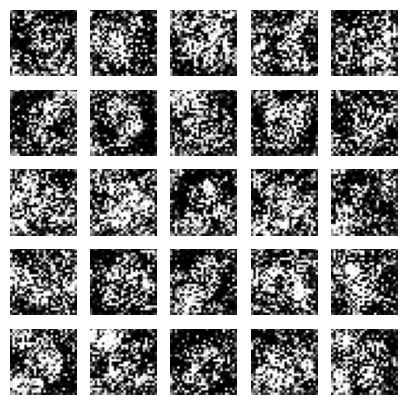

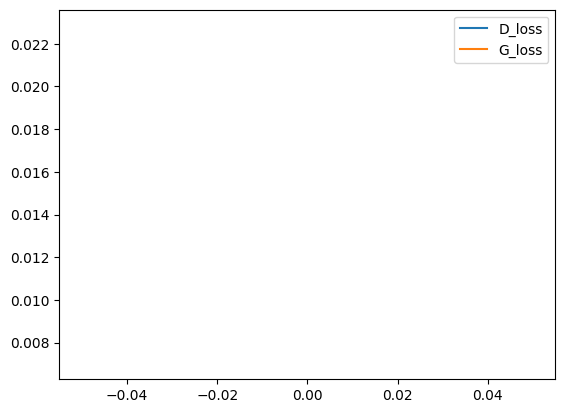

Epoch: 2


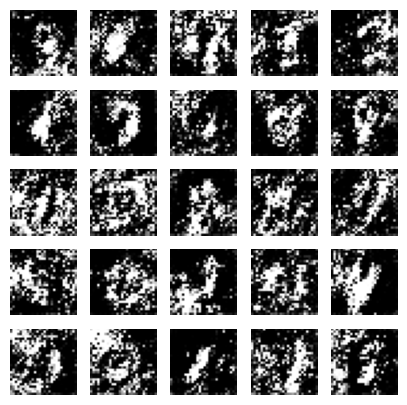

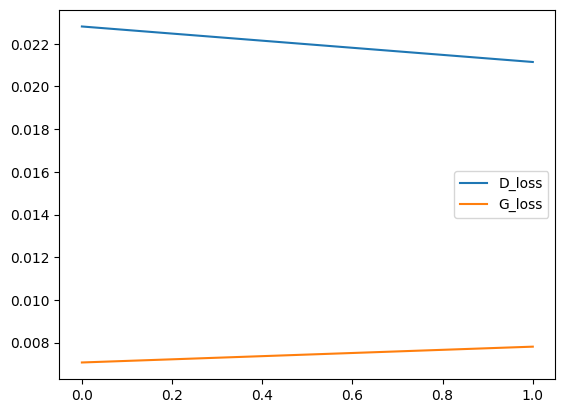

Epoch: 3


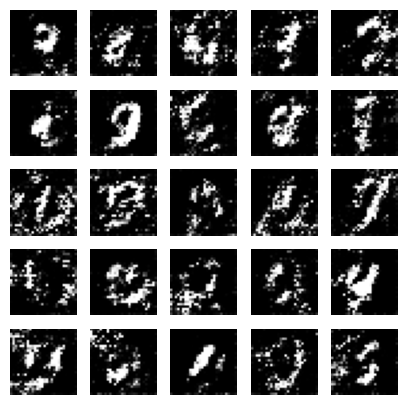

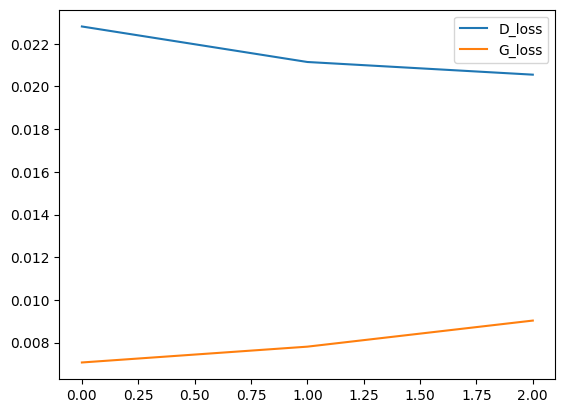

Epoch: 4


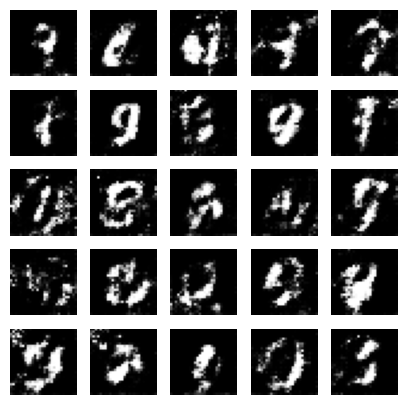

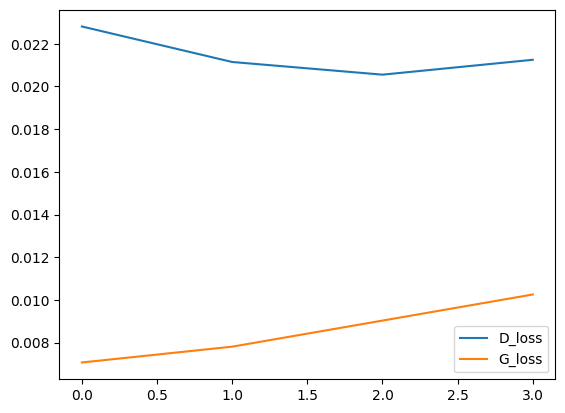

Epoch: 5


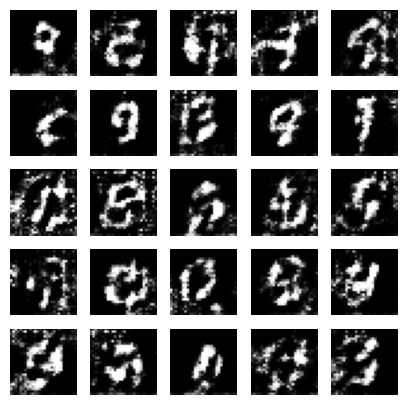

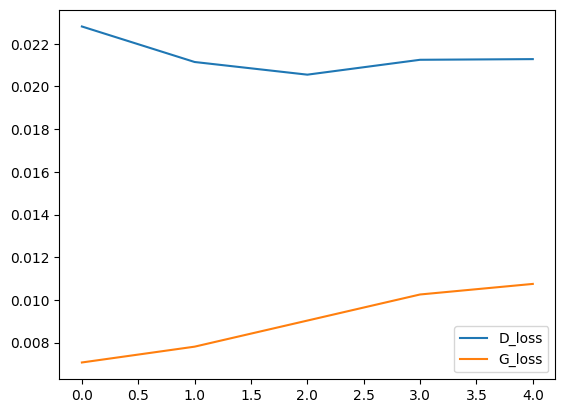

Epoch: 6


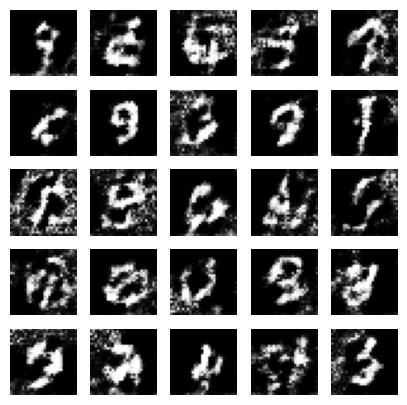

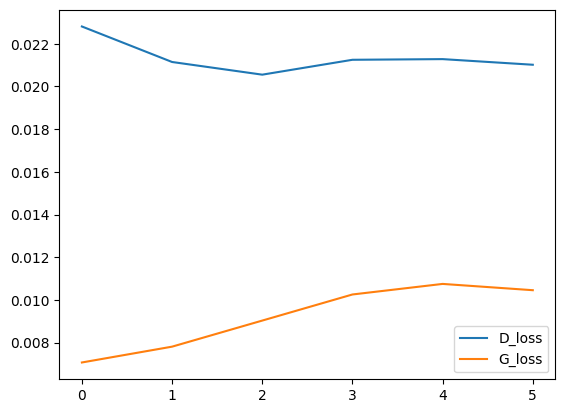

Epoch: 7


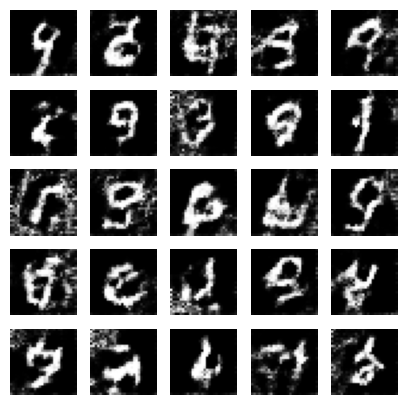

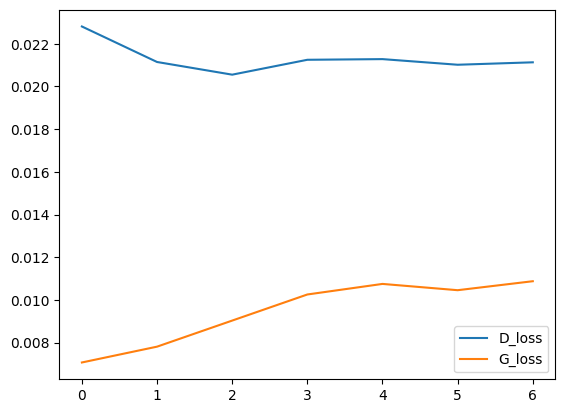

Epoch: 8


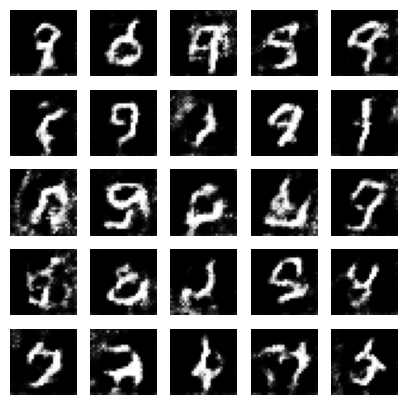

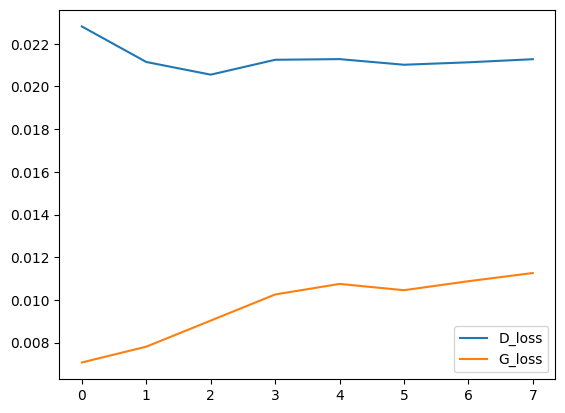

Epoch: 9


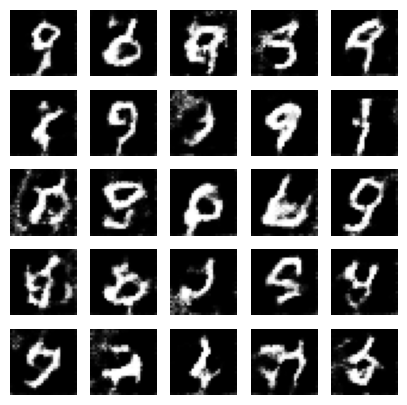

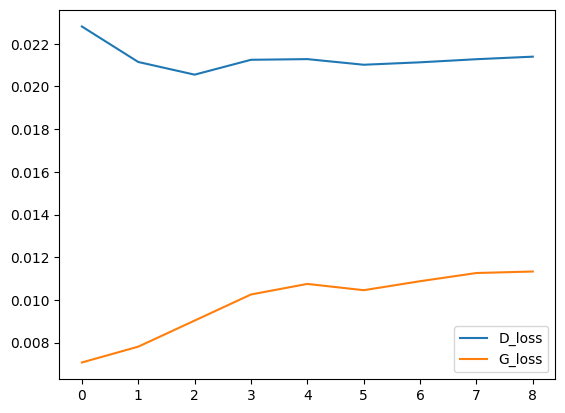

Epoch: 10


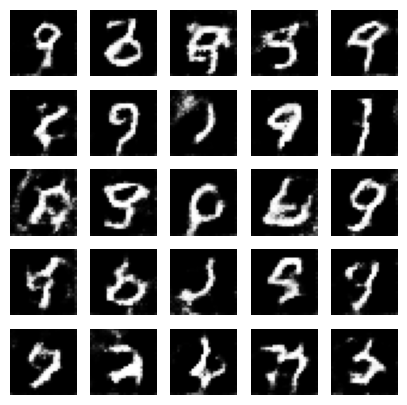

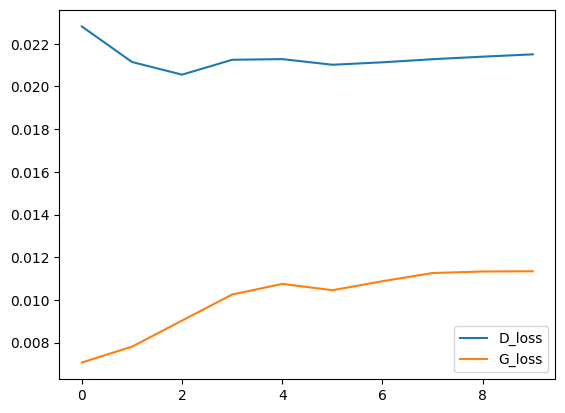

Epoch: 11


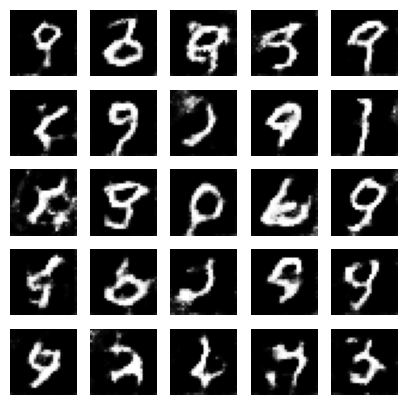

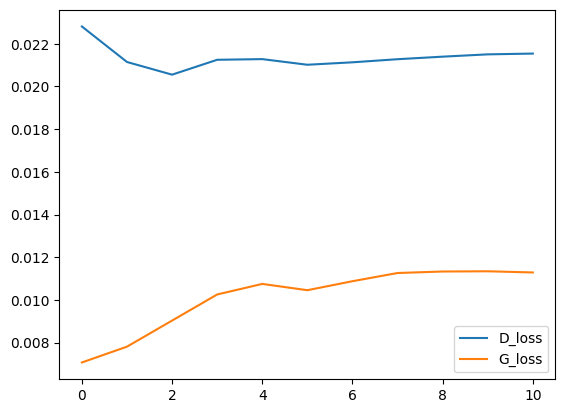

Epoch: 12


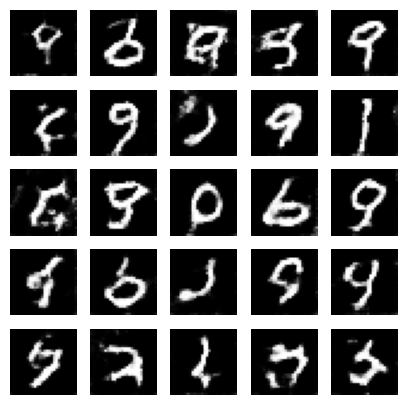

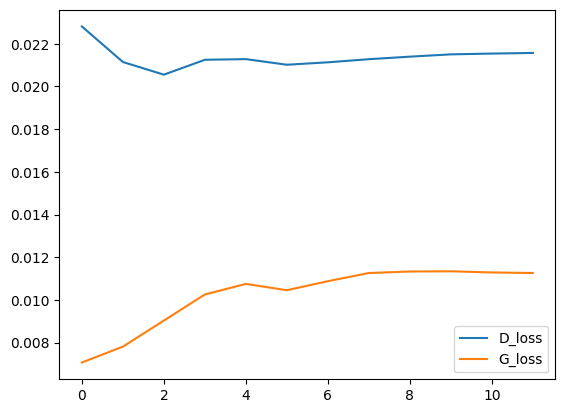

Epoch: 13


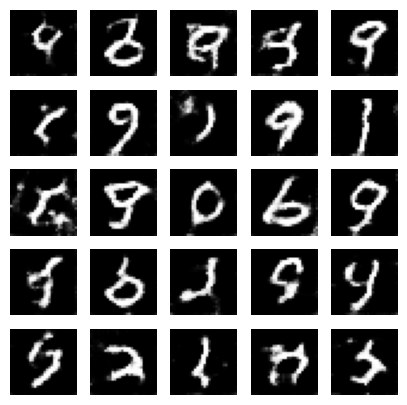

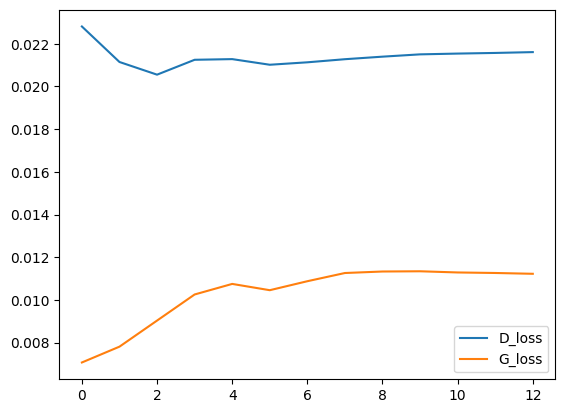

Epoch: 14


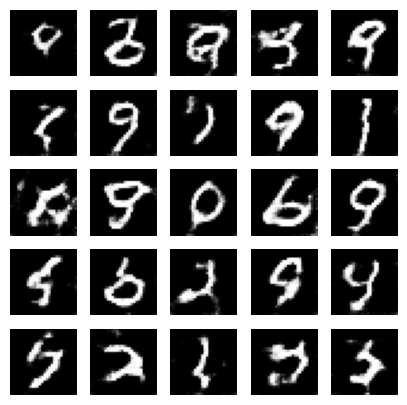

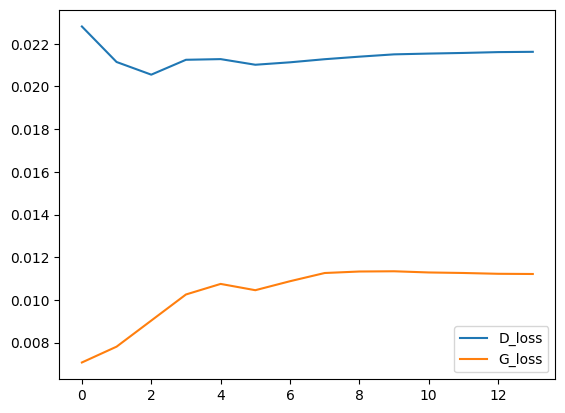

Epoch: 15


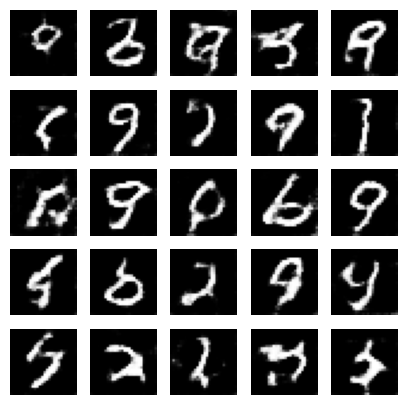

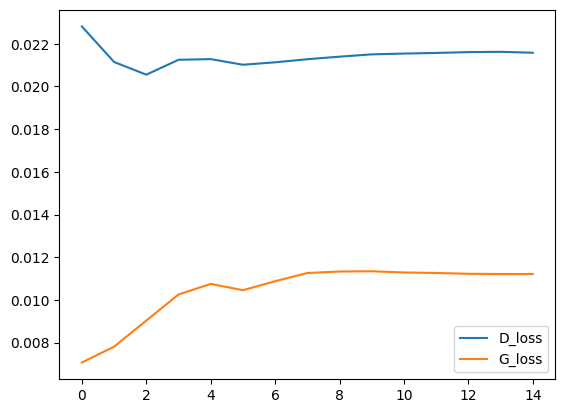

Epoch: 16


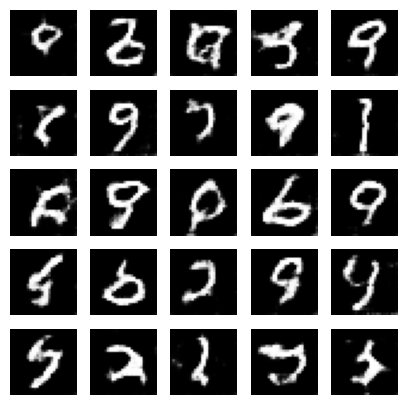

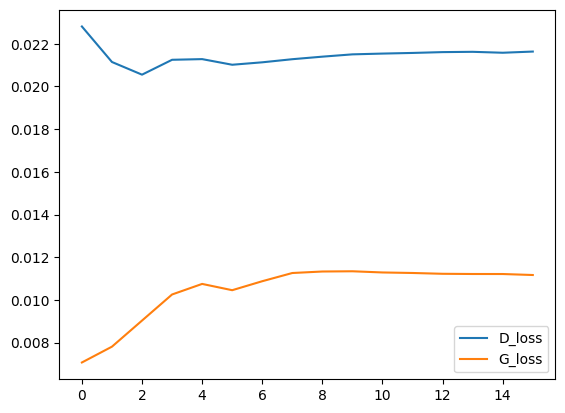

Epoch: 17


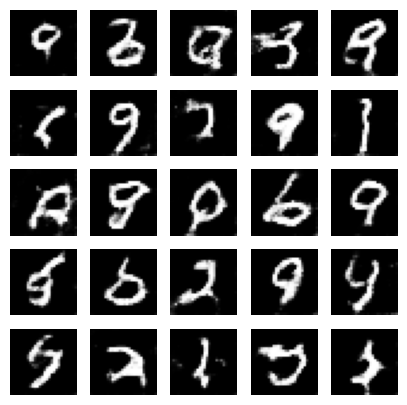

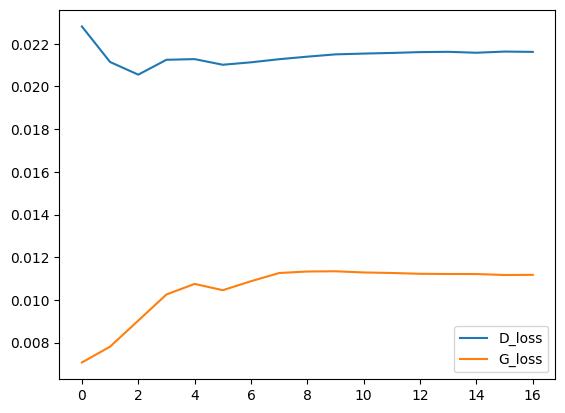

Epoch: 18


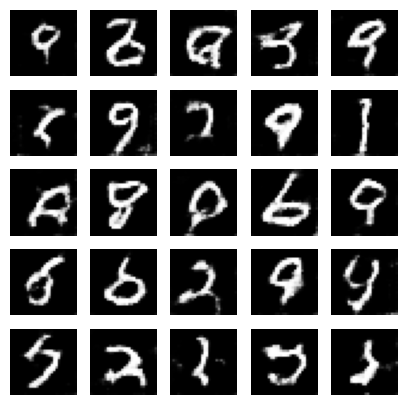

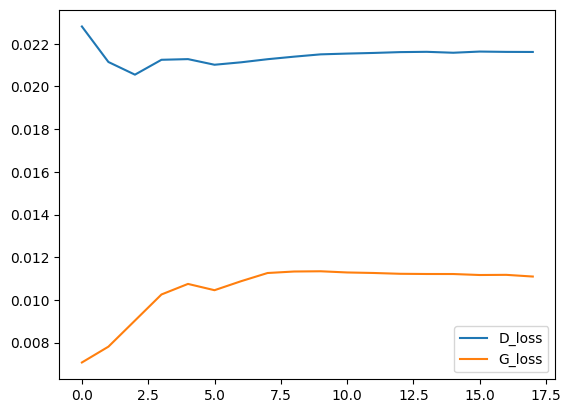

Epoch: 19


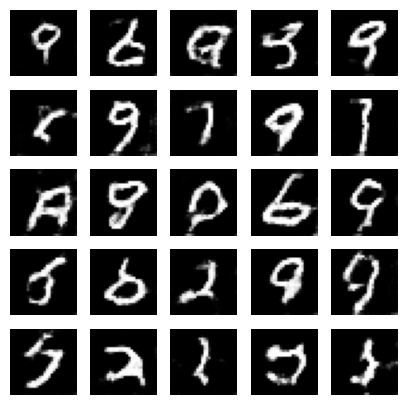

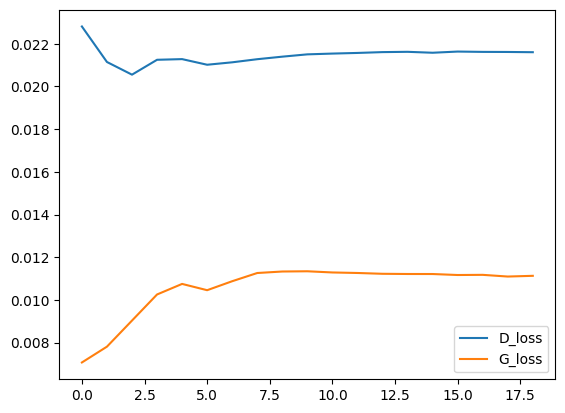

Epoch: 20


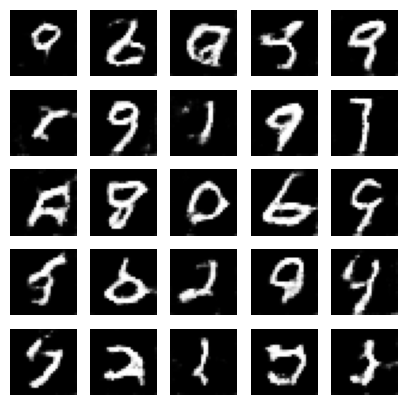

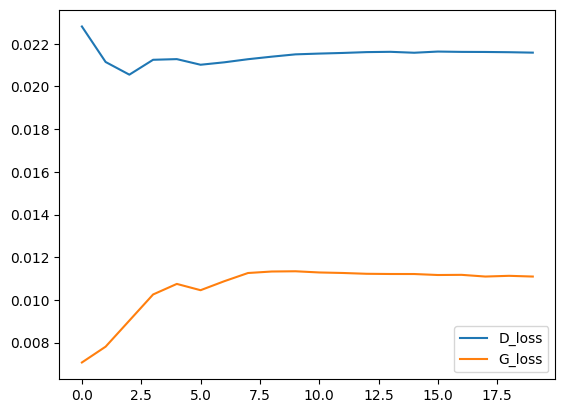

Epoch: 21


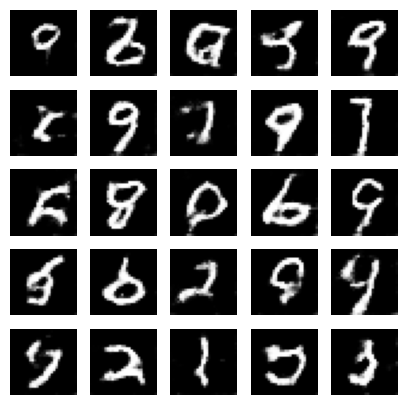

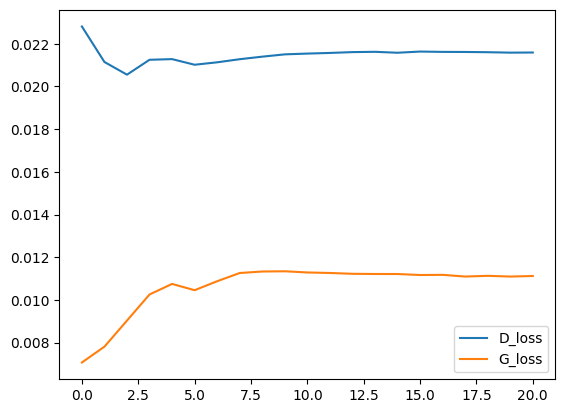

Epoch: 22


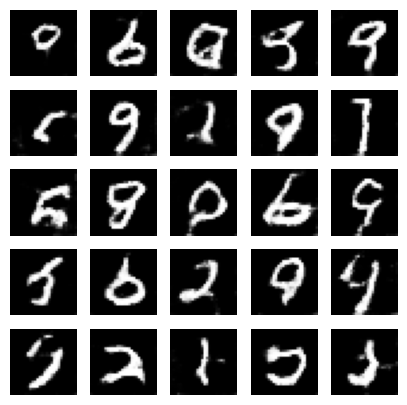

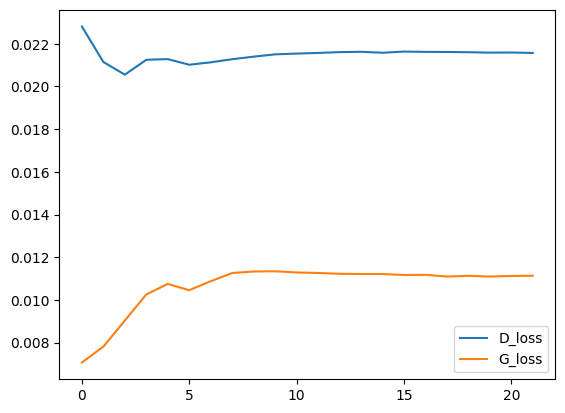

Epoch: 23


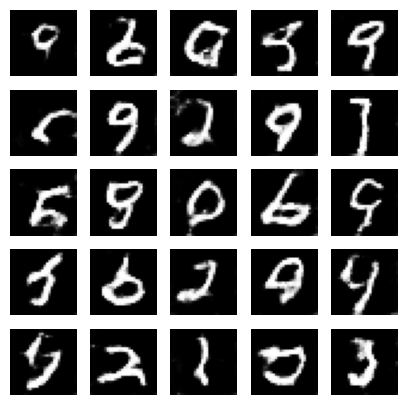

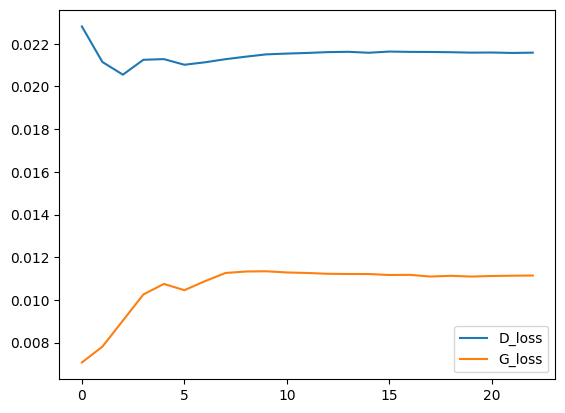

Epoch: 24


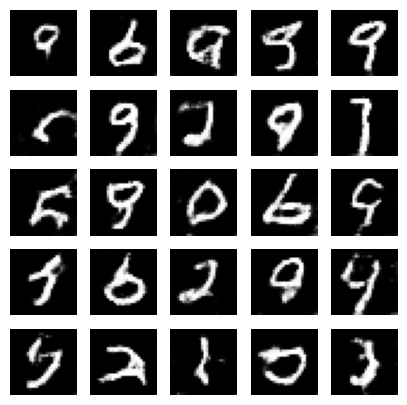

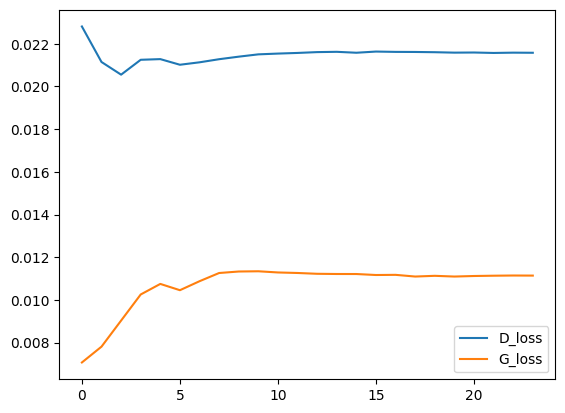

Epoch: 25


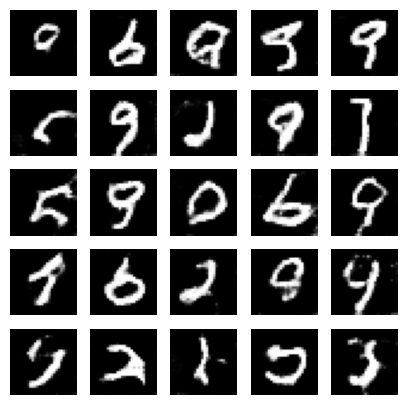

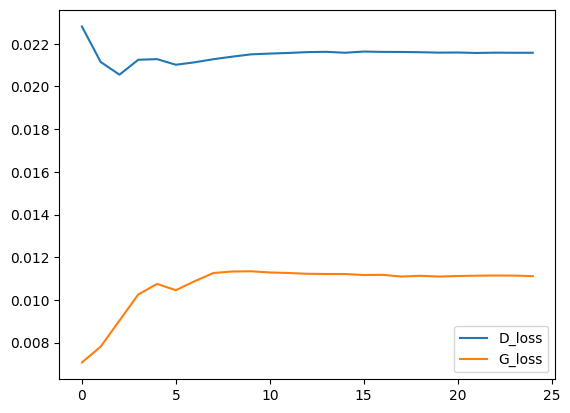

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

# 数据归一化(-1,1)
transform = transforms.Compose([
    transforms.ToTensor(),  # 0-1
    transforms.Normalize(0.5, 0.5)  # 均值0.5方差0.5
])
# 加载内置数据集
train_ds = torchvision.datasets.MNIST('data',
                                      train=True,
                                      transform=transform,
                                      download=True)

dataloader = torch.utils.data.DataLoader(train_ds,
                                         batch_size=64,
                                         shuffle=True)

# 定义生成器，依然输入长度100的噪声
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(100, 256*7*7)
        self.bn1 = nn.BatchNorm1d(256*7*7)
        self.deconv1 = nn.ConvTranspose2d(256, 128,
                                          kernel_size=(3, 3),
                                          stride=1,
                                          padding=1
                                          )
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64,
                                          kernel_size=(4, 4),
                                          stride=2,
                                          padding=1
                                          )
        self.bn3 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 1,
                                          kernel_size=(4, 4),
                                          stride=2,
                                          padding=1
                                          )

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.bn1(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.deconv1(x))
        x = self.bn2(x)
        x = F.relu(self.deconv2(x))
        x = self.bn3(x)
        x = torch.tanh(self.deconv3(x))
        return x


# 判别器,输入（28，28）图片
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 128, 3, 2)
        self.bn = nn.BatchNorm2d(128)
        self.fc = nn.Linear(128*6*6, 1)

    def forward(self, x):
        x = F.dropout2d(F.leaky_relu(self.conv1(x)), p=0.3)
        x = F.dropout2d(F.leaky_relu(self.conv2(x)), p=0.3)
        x = self.bn(x)
        x = x.view(-1, 128*6*6)
        x = torch.sigmoid(self.fc(x))
        return x


device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print('using cuda:', torch.cuda.get_device_name(0))

Gen = Generator().to(device)
Dis = Discriminator().to(device)

loss_fun = nn.BCELoss()
d_optimizer = torch.optim.Adam(Dis.parameters(), lr=1e-5)  # 小技巧
g_optimizer = torch.optim.Adam(Gen.parameters(), lr=1e-4)


def generate_and_save_image(model, test_input):
    predictions = np.squeeze(model(test_input).cpu().numpy())
    fig = plt.figure(figsize=(5, 5))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow((predictions[i]+1) / 2, cmap='gray')
        plt.axis('off')
    plt.show()

test_input = torch.randn(25, 100, device=device)
D_loss = []
G_loss = []

for epoch in range(25):
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader.dataset)
    for step, (img, _) in enumerate(dataloader):
        img = img.to(device)
        size = img.size(0)
        random_noise = torch.randn(size, 100, device=device)

        d_optimizer.zero_grad()
        real_output = Dis(img)  # 判别器输入真实图片
        # 判别器在真实图像上的损失
        d_real_loss = loss_fun(real_output,
                                    torch.ones_like(real_output)
                                    )
        d_real_loss.backward()

        gen_img = Gen(random_noise)
        fake_output = Dis(gen_img.detach())  # 判别器输入生成图片,fake_output对生成图片的预测
        # gen_img是由生成器得来的，但我们现在只对判别器更新，所以要截断对Gen的更新
        # detach()得到了没有梯度的tensor，求导到这里就停止了，backward的时候就不会求导到Gen了

        d_fake_loss = loss_fun(fake_output,
                                    torch.zeros_like(fake_output)
                                    )
        d_fake_loss.backward()
        d_loss = d_real_loss + d_fake_loss
        d_optimizer.step()

        # 更新生成器
        g_optimizer.zero_grad()
        fake_output = Dis(gen_img)
        g_loss = loss_fun(fake_output,
                               torch.ones_like(fake_output))
        g_loss.backward()
        g_optimizer.step()

        with torch.no_grad():
            d_epoch_loss += d_loss.item()
            g_epoch_loss += g_loss.item()

    with torch.no_grad():  # 之后的内容不进行梯度的计算（图的构建）
        d_epoch_loss /= count
        g_epoch_loss /= count
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)
        print('Epoch:', epoch+1)
        generate_and_save_image(model=Gen, test_input=test_input)

    plt.plot(D_loss, label='D_loss')
    plt.plot(G_loss, label='G_loss')
    plt.legend()
    plt.show()


